<a href="https://colab.research.google.com/github/webjjang/data_anal/blob/main/ml_ch13_part2_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 필요한 라이브러리 import
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

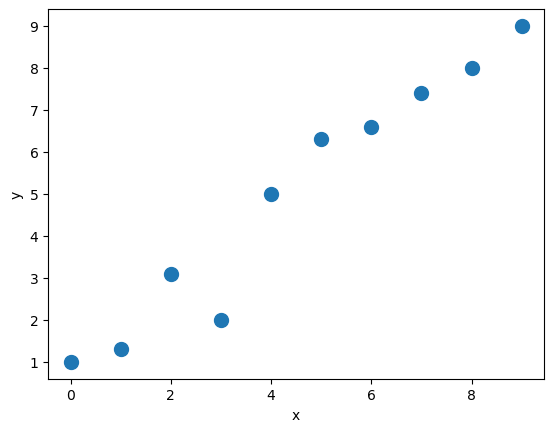

In [ ]:
# 간단한 데이터 셋 만들기와 시각화

# 0~9까지의 숫자를 만들어 2차 행렬로 만듬.
X_train = np.arange(10).reshape((10, 1))
# y의 값을 1~9 사이의 값 - 선형이 되도록 세팅
y_train = np.array([1.0, 1.3, 3.1,
                    2.0, 5.0, 6.3,
                    6.6, 7.4, 8.0,
                    9.0])


plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')
# plt.savefig('images/13_5.png', dpi=300)
plt.show()

In [ ]:
# 데이터 값의 표준화와 tf의 데이터셋 만들기

# X의 값들에 대해 표준화(평균이 0, 표준 편차가 1) 값을 구함.
"""
X_train: 입력 데이터 (예: 이미지, 특성 벡터 등)
np.mean(X_train): 전체 평균
np.std(X_train): 전체 표준편차
➡️ 각 특성 값을 평균 0, 표준편차 1로 맞추는 표준화 (Standardization) 작업입니다.
"""
X_train_norm = (X_train - np.mean(X_train))/np.std(X_train)

print(X_train)
print(X_train_norm)
"""
from_tensor_slices(...): NumPy 배열을 TensorFlow Dataset 객체로 변환
tf.cast(..., tf.float32): 자료형을 float32로 변환 (모델 학습에 적합한 형식)
➡️ 이렇게 만든 ds_train_orig는 Keras 모델 학습 시 model.fit()에 직접 넣을 수 있는 데이터 파이프라인이 됩니다.
orig - original : 원본 데이터 셋
"""
ds_train_orig = tf.data.Dataset.from_tensor_slices(
    (tf.cast(X_train_norm, tf.float32),
     tf.cast(y_train, tf.float32)))
print(ds_train_orig)

[[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]]
[[-1.5666989 ]
 [-1.21854359]
 [-0.87038828]
 [-0.52223297]
 [-0.17407766]
 [ 0.17407766]
 [ 0.52223297]
 [ 0.87038828]
 [ 1.21854359]
 [ 1.5666989 ]]
<_TensorSliceDataset element_spec=(TensorSpec(shape=(1,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>


In [ ]:
# 기계학습 모델 만들기와 초기화시키고 구조 확인하기

class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        """
        하지만 여기서 중요한 점: tf.Variable을 직접 사용할 경우,
        model.summary()는 아무 내용도 출력하지 않을 수 있습니다.

        ❗️이유: tf.Variable은 Keras 레이어가 아니기 때문
        Keras의 summary()는 내부에 tf.keras.layers.Layer를 포함할 때만
        구조(입력, 출력, 파라미터 수)를 보여줍니다.

        당신의 모델에는 Dense 같은 레이어가 없고, 그냥 tf.Variable만 있어서
        아래처럼 출력될 수 있습니다:
        """
        # self.w = tf.Variable(0.0, name='weight')
        # bias - 편향, 편견
        # self.b = tf.Variable(0.0, name='bias')

        # add_weight를 사용하여 Keras가 추적 가능한 가중치로 등록
        self.w = self.add_weight(shape=(1,), initializer='zeros', trainable=True, name='weight')
        self.b = self.add_weight(shape=(1,), initializer='zeros', trainable=True, name='bias')

    def call(self, x):
        return self.w*x + self.b


model = MyModel()

model.build(input_shape=(None, 1))
model.summary()

Model: "my_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 손실을 구하는 함수

def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


## testing the function:
yt = tf.convert_to_tensor([1.0])
yp = tf.convert_to_tensor([1.5])

loss_fn(yt, yp)

<tf.Tensor: shape=(), dtype=float32, numpy=0.25>

In [ ]:
# 훈련시키는 함수
# 손실을 구해서 가중치와 절편에 적용시킨다.

def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as tape:
        current_loss = loss_fn(model(inputs), outputs)
    dW, db = tape.gradient(current_loss, [model.w, model.b])
    model.w.assign_sub(learning_rate * dW)
    model.b.assign_sub(learning_rate * db)

In [ ]:
# 기계학습 반복 시키기.

tf.random.set_seed(1)

num_epochs = 200
log_steps = 100
learning_rate = 0.001
batch_size = 1
steps_per_epoch = int(np.ceil(len(y_train) / batch_size))


ds_train = ds_train_orig.shuffle(buffer_size=len(y_train))
ds_train = ds_train.repeat(count=None)
ds_train = ds_train.batch(1)

Ws, bs = [], []

for i, batch in enumerate(ds_train):
    if i >= steps_per_epoch * num_epochs:
        break
    Ws.append(model.w.numpy())
    bs.append(model.b.numpy())

    bx, by = batch
    loss_val = loss_fn(model(bx), by)

    train(model, bx, by, learning_rate=learning_rate)
    if i%log_steps==0:
        print('에포크 {:3d} 스텝 {:4d} 손실 {:6.4f}'.format(
              int(i/steps_per_epoch), i, loss_val))

에포크   0 스텝    0 손실 43.5600
에포크  10 스텝  100 손실 0.7530
에포크  20 스텝  200 손실 20.1759
에포크  30 스텝  300 손실 23.3976
에포크  40 스텝  400 손실 6.3481
에포크  50 스텝  500 손실 4.6356
에포크  60 스텝  600 손실 0.2411
에포크  70 스텝  700 손실 0.2036
에포크  80 스텝  800 손실 3.8177
에포크  90 스텝  900 손실 0.9416
에포크 100 스텝 1000 손실 0.7035
에포크 110 스텝 1100 손실 0.0348
에포크 120 스텝 1200 손실 0.5404
에포크 130 스텝 1300 손실 0.1170
에포크 140 스텝 1400 손실 0.1195
에포크 150 스텝 1500 손실 0.0944
에포크 160 스텝 1600 손실 0.4670
에포크 170 스텝 1700 손실 2.0695
에포크 180 스텝 1800 손실 0.0020
에포크 190 스텝 1900 손실 0.3612


최종 파라미터: [2.6576622] [4.8798566]


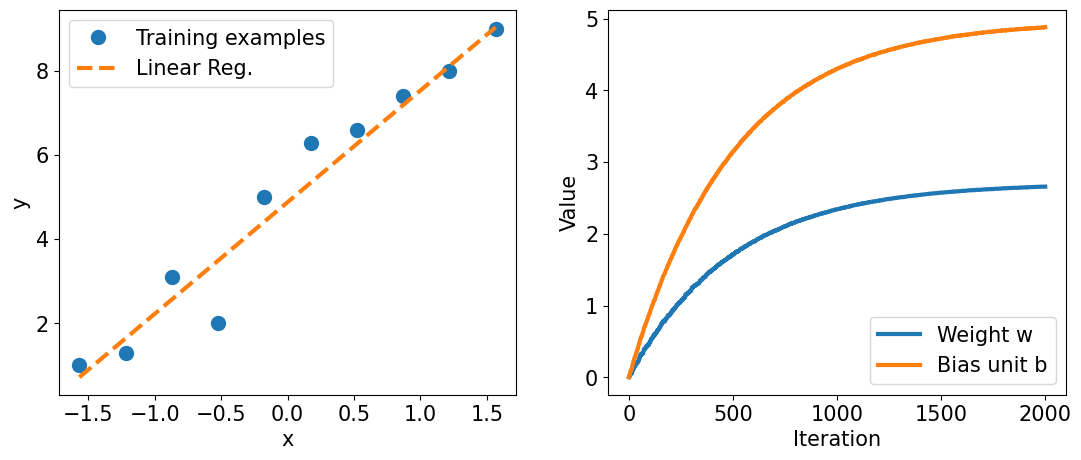

In [ ]:
# 기계학습한 결과 출력하기
# 위에 기계학습 코드를 여러번 실행하면 중간 단계의 학습 결과만 출력되어 그래프가 달라짐.

print('최종 파라미터:', model.w.numpy(), model.b.numpy())


X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear Reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['Weight w', 'Bias unit b'], fontsize=15)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Value', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

# plt.savefig('images/13_6.png', dpi=300)
plt.show()

In [ ]:
# tf.keras.Model 을 상속받았으므로 초기값 세팅을 위한 compile()와
# 훈련함수 fit()을 사용할 수 있음.

tf.random.set_seed(1)
model = MyModel()
#model.build((None, 1))

model.compile(optimizer='sgd',
              loss=loss_fn,
              metrics=['mae', 'mse'])

In [ ]:
# 모델 훈련 시키기.

model.fit(X_train_norm, y_train,
          epochs=num_epochs, batch_size=batch_size,
          verbose=1)

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24.1936 - mae: 4.2272 - mse: 24.1936
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.3219 - mae: 3.4892 - mse: 16.3219
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.0623 - mae: 2.8868 - mse: 11.0623
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5438 - mae: 2.3950 - mse: 7.5438 
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1866 - mae: 2.0062 - mse: 5.1866 
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6047 - mae: 1.6925 - mse: 3.6047 
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5408 - mae: 1.4364 - mse: 2.5408 
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8235 - mae: 1.2274 - mse: 1.8235 
Epoch 9/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3383 - mae: 1.0643 - mse: 1.3383 
Epoch 10/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0091 - mae: 0.9333 - mse: 1.0091 
Epoch 11/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms

[2.7240849] [4.9556704]


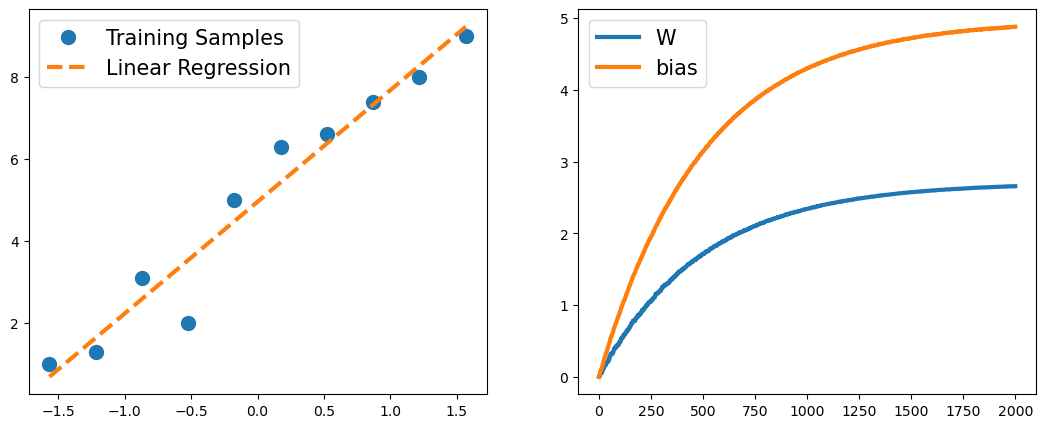

In [ ]:
# 훈련시킨 결과 그래프로 출력하기

print(model.w.numpy(), model.b.numpy())


X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training Samples', 'Linear Regression'], fontsize=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['W', 'bias'], fontsize=15)
plt.show()

## 붓꽃 데이터셋을 분류하는 다층 퍼셉트론 만들기

In [ ]:
# tensorflow_datasets 의 붓꽃 데이터 셋 로드하기
# 데이터를 가져오는데 시간이 걸려서 경고가 나오는데 한번 더 실행하세요.~~~

import tensorflow_datasets as tfds

iris, iris_info = tfds.load('iris', with_info=True)

print(iris_info)

tfds.core.DatasetInfo(
    name='iris',
    full_name='iris/2.1.0',
    description="""
    This is perhaps the best known database to be found in the pattern recognition
    literature. Fisher's paper is a classic in the field and is referenced
    frequently to this day. (See Duda & Hart, for example.) The data set contains
    3 classes of 50 instances each, where each class refers to a type of iris
    plant. One class is linearly separable from the other 2; the latter are NOT
    linearly separable from each other.
    """,
    homepage='https://archive.ics.uci.edu/ml/datasets/iris',
    data_dir='C:\\Users\\webjjang\\tensorflow_datasets\\iris\\2.1.0',
    file_format=tfrecord,
    download_size=3.65 KiB,
    dataset_size=7.62 KiB,
    features=FeaturesDict({
        'features': Tensor(shape=(4,), dtype=float32),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('features', 'label'),
    disable_shuffling=False,
    nondeterministic_or

In [ ]:
# 가져온 데이터를 train만 선별하여 꺼내오기

# 섞어서 150개를 꺼내옴
tf.random.set_seed(1)

ds_orig = iris['train']
print(len(ds_orig))
ds_orig = ds_orig.shuffle(150, reshuffle_each_iteration=False)

print(next(iter(ds_orig)))

# 앞에서 100개는 훈련용 데이터로 50개는 테스트 데이터로 분리 저장함.
ds_train_orig = ds_orig.take(100)
ds_test = ds_orig.skip(100)

150
{'features': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([6.5, 3. , 5.2, 2. ], dtype=float32)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=2>}


In [ ]:
## 샘플 개수 확인

# n = 0
# for example in ds_train_orig:
#     n += 1
# print(n)

# n = 0
# for example in ds_test:
#     n += 1
# print(n)

print(len(ds_train_orig))
print(len(ds_test))

100
50


In [ ]:
# 학습 데이터와 테스트 데이터의 구조 만들기

ds_train_orig = ds_train_orig.map(
    lambda x: (x['features'], x['label']))

ds_test = ds_test.map(
    lambda x: (x['features'], x['label']))

next(iter(ds_train_orig))

(<tf.Tensor: shape=(4,), dtype=float32, numpy=array([6.5, 3. , 5.2, 2. ], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=int64, numpy=2>)

In [ ]:
# iris 학습 모델 만들기 - 다층 퍼셉트론 모델(Multi-Layer Perceptron, MLP)
# 처음에 경고가 나타남

iris_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='sigmoid',
                          name='fc1', input_shape=(4,)),
    tf.keras.layers.Dense(3, name='fc2', activation='softmax')])

"""
🔍 상세 설명
1️⃣ tf.keras.Sequential([...])
Sequential 모델은 여러 층을 순차적으로 쌓는 구조입니다.

복잡한 분기나 병렬 연결 없이 단순한 feed-forward 네트워크를 만들 때 사용합니다.

2️⃣ Dense(16, activation='sigmoid', name='fc1', input_shape=(4,))
🔸 Dense 레이어
완전 연결층 (fully connected layer, FC).

이 레이어는 입력값에 대해 가중치 곱과 편향을 더한 후, **비선형 함수(sigmoid)**를 적용합니다.

🔸 파라미터 설명
속성	설명
16	출력 뉴런 수 → 이 레이어의 출력은 shape (None, 16)
activation='sigmoid'	시그모이드 비선형 활성화 함수 사용 → 0~1 범위
name='fc1'	이 레이어에 대한 명칭 (모델 summary에 표시됨)
input_shape=(4,)	입력 벡터는 4개의 실수 값 (Iris 특성: 꽃받침 길이, 꽃받침 너비, 꽃잎 길이, 꽃잎 너비 등)

🔸 파라미터 수
가중치: 4(inputs) * 16(outputs) = 64

편향: 16

총: 64 + 16 = 80개

3️⃣ Dense(3, name='fc2', activation='softmax')
🔸 출력층 (Output Layer)
3개의 노드: Iris의 3개 클래스에 대한 확률 출력

예: setosa, versicolor, virginica

activation='softmax': 각 클래스에 대한 확률을 나타내며, 전체 합은 1

🔸 파라미터 수
가중치: 16(inputs) * 3(outputs) = 48

편향: 3

총: 48 + 3 = 51개

📊 전체 요약
레이어 이름	출력 Shape	파라미터 수	비고
fc1 (Dense)	(None, 16)	80	시그모이드 활성화
fc2 (Dense)	(None, 3)	51	소프트맥스 활성화
총합		131	모두 학습 가능

🧠 모델의 목적
이 모델은 다중 클래스 분류(multi-class classification)를 위한 것입니다. 특히:

입력: 4개의 연속형 특성 (Iris 데이터 특성)
출력: 각 샘플에 대해 3개 클래스 중 하나의 확률 분포

손실 함수로는 일반적으로 categorical_crossentropy 또는 sparse_categorical_crossentropy를 사용합니다.
"""

iris_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ fc1 (Dense)                          │ (None, 16)                  │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc2 (Dense)                          │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 131 (524.00 B)

 Trainable params: 131 (524.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 학습 모델 초기화
#iris_model을 학습하기 위한 준비 단계로, 모델의 학습 방식과 평가 지표를 정의
"""
🔍 상세 설명
1️⃣ optimizer='adam'
Adam 옵티마이저는 확률적 경사 하강법(SGD)의 변형 중 하나로, 적응형 학습률을 사용합니다.
일반적으로 성능이 좋고 다양한 문제에 잘 작동하기 때문에 기본값처럼 자주 사용됩니다.
내부적으로 momentum과 RMSprop을 결합한 알고리즘입니다.

2️⃣ loss='sparse_categorical_crossentropy'
다중 클래스 분류 문제에서 사용하는 손실 함수입니다.
sparse_가 붙은 이유:
정답 레이블이 정수 형태 (예: [0, 1, 2])일 때 사용합니다.
만약 정답이 one-hot 인코딩(예: [1, 0, 0]) 형태라면 categorical_crossentropy를 사용해야 합니다.
Iris 분류 문제에서 일반적으로 y = [0, 1, 2] 같은 정수 레이블을 사용하므로 sparse_ 버전이 적절합니다.

3️⃣ metrics=['accuracy']
모델 성능 평가 지표로 정확도(accuracy) 를 사용합니다.
예측값 중 정답과 일치한 비율을 계산합니다.

🎯 전체 의미
이 compile() 코드는 다음과 같은 의미입니다:
"Adam 최적화를 사용해서, 정수 레이블을 위한 분류 손실(sparse categorical crossentropy)을 줄이는 방향으로 학습하고, 훈련 및 평가 과정에서 정확도를 모니터링하겠다."
"""
iris_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [ ]:
# 100개의 훈련 데이터로 기계학습 진행하고 결과 바

num_epochs = 100
training_size = 100
batch_size = 2
# 반복 단계는 정수 타입이여야 하는데 나누기를 하면 실수 타입이 됨.
steps_per_epoch = int(np.ceil(training_size / batch_size))

ds_train = ds_train_orig.shuffle(buffer_size=training_size)
ds_train = ds_train.repeat()
ds_train = ds_train.batch(batch_size=batch_size)
ds_train = ds_train.prefetch(buffer_size=1000)

history = iris_model.fit(ds_train, epochs=num_epochs,
                         steps_per_epoch=steps_per_epoch,
                         verbose=0)


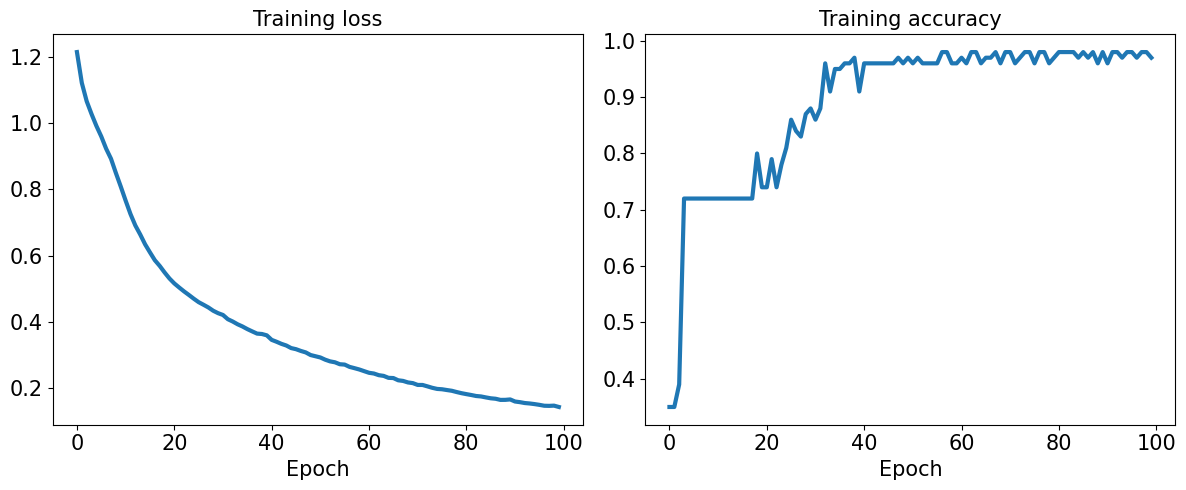

In [ ]:
# 훈련 결과 그래그 출력

hist = history.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
# plt.savefig('images/13_7.png', dpi=300)
plt.show()

In [ ]:
# 훈련된 모델 평가하기

results = iris_model.evaluate(ds_test.batch(50), verbose=0)
print('테스트 손실: {:.4f}   테스트 정확도: {:.4f}'.format(*results))

테스트 손실: 0.1435   테스트 정확도: 0.9600


In [ ]:
# 훈편된 모델 저장하기

# iris_model.save('iris-classifier.h5',
#                 overwrite=True,
#                 include_optimizer=True,
#                 save_format='h5')

# keras 3 에서 저장 방식이 달라짐.
# Keras 3부터는 save_format 인자가 더 이상 필요하지 않고, 파일 확장자에 따라 자동으로 저장 형식이 결정
"""
🔁 참고: Keras 3 저장 방식 요약
파일명 예	저장 형식	비고
'model.keras' - Keras v3 전용 포맷 / 권장 (미래 호환)
'model.h5' - HDF5 (Keras v2 호환) / 호환성 목적
'model'(확장자 없음) - SavedModel 디렉터리 / TF 서빙 등에서 사용
"""

iris_model.save('iris-classifier.keras',
                overwrite=True,
                include_optimizer=True)


In [ ]:
# 저장된 훈련된 훈련 모델 불러오기 - 2번 실행하세요

iris_model_new = tf.keras.models.load_model('iris-classifier.keras')

iris_model_new.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ fc1 (Dense)                          │ (None, 16)                  │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc2 (Dense)                          │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 264 (1.04 KB)

 Trainable params: 131 (524.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 133 (536.00 B)

## 훈련된 모델 사용하기

In [ ]:
# 훈련된 모델 사용하기

# 예시 입력 데이터: 꽃받침 길이/너비, 꽃잎 길이/너비
# 예: [5.1, 3.5, 1.4, 0.2]는 setosa로 분류될 가능성이 높음
new_samples = np.array([
    [5.1, 3.5, 1.4, 0.2],  # setosa
    [6.0, 2.2, 4.0, 1.0],  # versicolor
    [6.3, 3.3, 6.0, 2.5]   # virginica
], dtype=np.float32)

# 예측
predictions = iris_model_new.predict(new_samples)

# 예측 결과 출력
for i, probs in enumerate(predictions):
    predicted_class = np.argmax(probs)
    print(f"샘플 {i+1}: 예측된 클래스 = {predicted_class}, 확률 분포 = {probs}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
샘플 1: 예측된 클래스 = 0, 확률 분포 = [9.925505e-01 7.446777e-03 2.705976e-06]
샘플 2: 예측된 클래스 = 1, 확률 분포 = [0.02471963 0.923719   0.0515614 ]
샘플 3: 예측된 클래스 = 2, 확률 분포 = [6.6757195e-05 3.6790568e-02 9.6314269e-01]
